# Detecting Financial Impulse Behaviour in Young Adults
Complete Behavioural Analytics Pipeline


In [253]:

import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix


## Step 1: Load Dataset

In [254]:
df = pd.read_csv("/content/synthetic_financial_impulse_dataset.csv")
print(df.head())

   user_id     transaction_time   amount merchant_category  hour_of_day  \
0      447  2024-05-24 08:32:00  1193.47       Electronics            8   
1      397  2024-02-15 02:05:00   450.72             Bills            2   
2      256  2024-02-16 01:09:00   804.87             Bills            1   
3      177  2024-01-11 20:25:00    16.33             Bills           20   
4      342  2024-02-28 16:12:00   302.27            Travel           16   

   weekend_flag  night_transaction  discretionary_category  spending_spike  \
0             0                  0                       1               1   
1             0                  1                       0               0   
2             0                  1                       0               1   
3             0                  1                       0               0   
4             0                  0                       0               0   

   short_time_gap  end_month_flag  impulse_label  
0               0            

## Step 2: Aggregate User Behaviour Features

In [255]:

user_features = df.groupby("user_id").agg({
    "amount": ["mean", "std"],
    "night_transaction": "mean",
    "weekend_flag": "mean",
    "discretionary_category": "mean",
    "spending_spike": "mean",
    "short_time_gap": "mean",
    "end_month_flag": "mean",
    "impulse_label": "mean"
})

user_features.columns = ["avg_amount", "amount_std",
                         "night_ratio", "weekend_ratio",
                         "discretionary_ratio",
                         "spike_ratio", "short_gap_ratio",
                         "end_month_ratio",
                         "impulse_ratio"]

user_features.reset_index(inplace=True)

user_features.head()


,user_id,avg_amount,amount_std,night_ratio,weekend_ratio,discretionary_ratio,spike_ratio,short_gap_ratio,end_month_ratio,impulse_ratio
0,1,278.714194,241.701789,0.290323,0.258065,0.387097,0.322581,0.096774,0.258065,0.096774
1,2,479.830000,393.068252,0.340909,0.295455,0.454545,0.295455,0.181818,0.227273,0.159091
2,3,512.513684,465.137536,0.315789,0.289474,0.394737,0.289474,0.157895,0.105263,0.131579
3,4,480.013500,379.151862,0.250000,0.250000,0.525000,0.425000,0.225000,0.300000,0.275000
4,5,399.910857,330.713387,0.485714,0.285714,0.457143,0.600000,0.085714,0.228571,0.228571


## Step 3: Behavioural Clustering (K-Means)

In [256]:

clustering_features = user_features.drop(["user_id", "impulse_ratio"], axis=1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_features)

kmeans = KMeans(n_clusters=4, random_state=42)
user_features["cluster"] = kmeans.fit_predict(scaled_data)

user_features.head()


,user_id,avg_amount,amount_std,night_ratio,weekend_ratio,discretionary_ratio,spike_ratio,short_gap_ratio,end_month_ratio,impulse_ratio,cluster
0,1,278.714194,241.701789,0.290323,0.258065,0.387097,0.322581,0.096774,0.258065,0.096774,0
1,2,479.830000,393.068252,0.340909,0.295455,0.454545,0.295455,0.181818,0.227273,0.159091,3
2,3,512.513684,465.137536,0.315789,0.289474,0.394737,0.289474,0.157895,0.105263,0.131579,3
3,4,480.013500,379.151862,0.250000,0.250000,0.525000,0.425000,0.225000,0.300000,0.275000,2
4,5,399.910857,330.713387,0.485714,0.285714,0.457143,0.600000,0.085714,0.228571,0.228571,0


## Step 4: Risk Classification Model

In [257]:

# Adjusted threshold for better balance
user_features["high_risk"] = (user_features["impulse_ratio"] > 0.25).astype(int)

print(user_features["high_risk"].value_counts())

X = user_features.drop(["user_id", "impulse_ratio", "high_risk"], axis=1)
y = user_features["high_risk"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42
)

model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.25).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


high_risk
0    413
1     87
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        80
           1       0.60      0.60      0.60        20

    accuracy                           0.84       100
   macro avg       0.75      0.75      0.75       100
weighted avg       0.84      0.84      0.84       100

ROC-AUC: 0.9046875000000001
Confusion Matrix:
 [[72  8]
 [ 8 12]]


## Step 5: Generate Risk Score (0-100)

In [258]:

user_features["risk_score"] = model.predict_proba(X)[:,1] * 100

def risk_level(score):
    if score <= 30:
        return "Low"
    elif score <= 70:
        return "Medium"
    else:
        return "High"

user_features["risk_level"] = user_features["risk_score"].apply(risk_level)

user_features[["user_id","risk_score","risk_level"]].head()


,user_id,risk_score,risk_level
0,1,2.5,Low
1,2,1.0,Low
2,3,0.5,Low
3,4,67.0,Medium
4,5,11.0,Low


## Step 6: Behaviour Profile & Recommendations

In [259]:

def behaviour_profile(row):
    if row["night_ratio"] > 0.4:
        return "Late-Night Impulsive Spender"
    elif row["discretionary_ratio"] > 0.5:
        return "Lifestyle-Oriented Spender"
    elif row["spike_ratio"] > 0.4:
        return "High Volatility Spender"
    else:
        return "Stable Budget Spender"

def generate_nudge(row):
    if row["risk_level"] == "High":
        return "Enable spending alerts and apply 24-hour cooling-off for discretionary purchases."
    elif row["risk_level"] == "Medium":
        return "Set weekly spending limit and monitor weekend expenses."
    else:
        return "Maintain current budgeting habits."

user_features["behaviour_profile"] = user_features.apply(behaviour_profile, axis=1)
user_features["recommendation"] = user_features.apply(generate_nudge, axis=1)

user_features[["user_id","risk_level","behaviour_profile","recommendation"]].head()


,user_id,risk_level,behaviour_profile,recommendation
0,1,Low,Stable Budget Spender,Maintain current budgeting habits.
1,2,Low,Stable Budget Spender,Maintain current budgeting habits.
2,3,Low,Stable Budget Spender,Maintain current budgeting habits.
3,4,Medium,Lifestyle-Oriented Spender,Set weekly spending limit and monitor weekend ...
4,5,Low,Late-Night Impulsive Spender,Maintain current budgeting habits.


In [260]:
feature_importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
print(feature_importance_df)

               feature  importance
5          spike_ratio    0.310485
4  discretionary_ratio    0.169964
7      end_month_ratio    0.139767
2          night_ratio    0.097332
6      short_gap_ratio    0.092635
0           avg_amount    0.067426
1           amount_std    0.058695
3        weekend_ratio    0.049766
8              cluster    0.013931


In [261]:
import joblib

joblib.dump(model, 'random_forest_model.joblib')
print("Model saved successfully as random_forest_model.joblib")

Model saved successfully as random_forest_model.joblib


In [262]:
model2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,
    min_samples_split=5,
    class_weight="balanced_subsample",
    random_state=42
)

In [263]:
model2.fit(X_train, y_train)

y_prob = model2.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.25).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89        80
           1       0.56      0.75      0.64        20

    accuracy                           0.83       100
   macro avg       0.74      0.80      0.76       100
weighted avg       0.86      0.83      0.84       100

ROC-AUC: 0.904375


In [264]:
!pip install shap

In [265]:
import shap

In [266]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

/tmp/ipython-input-204/2344957999.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test)


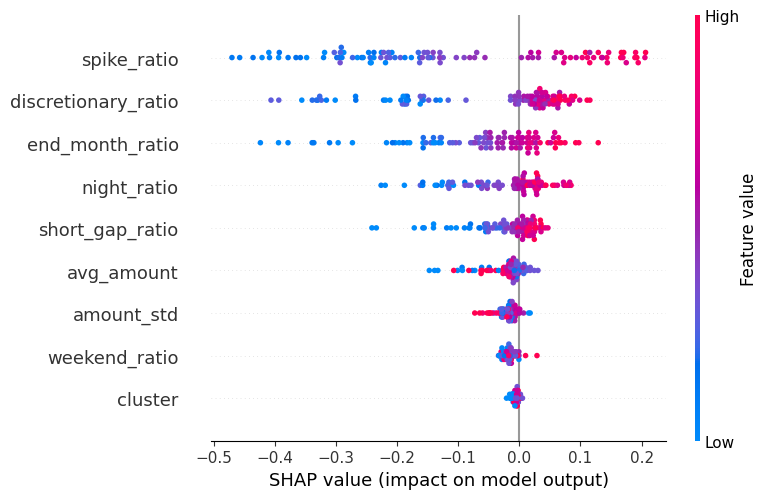

In [267]:
shap.summary_plot(shap_values[:, :, 1], X_test)

/tmp/ipython-input-204/3941835855.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", title="SHAP Feature Importance (Bar Plot)")


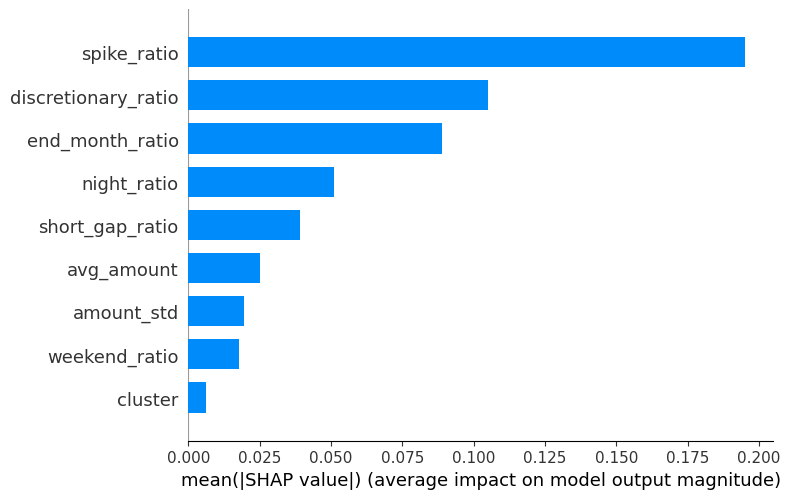

In [268]:
shap.summary_plot(shap_values[:, :, 1], X_test, plot_type="bar", title="SHAP Feature Importance (Bar Plot)")

In [269]:
shap.initjs()

index = 5  # any row

shap.force_plot(
    explainer.expected_value[1],
    shap_values[index, :, 1],
    X_test.iloc[index]
)

In [270]:
import joblib

joblib.dump(model2, 'random_forest_model2.joblib')
print("Model saved successfully as random_forest_model2.joblib")

Model saved successfully as random_forest_model2.joblib


## SMOTE

In [271]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

model3.fit(X_train_res, y_train_res)

RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [272]:
y_prob = model3.predict_proba(X_test)[:,1]
y_pred = (y_prob > 0.25).astype(int)

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87        80
           1       0.52      0.80      0.63        20

    accuracy                           0.81       100
   macro avg       0.73      0.81      0.75       100
weighted avg       0.86      0.81      0.82       100

ROC-AUC: 0.8871874999999999


In [273]:
import joblib

joblib.dump(model3, 'random_forest_model3.joblib')
print("Model saved successfully as random_forest_model3.joblib")

Model saved successfully as random_forest_model3.joblib


## Visualizations

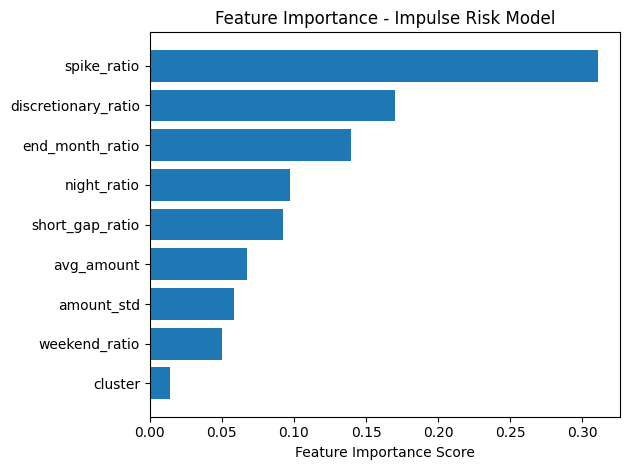

In [274]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
importances = model.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)

plt.figure()
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance Score")
plt.title("Feature Importance - Impulse Risk Model")
plt.tight_layout()
plt.show()

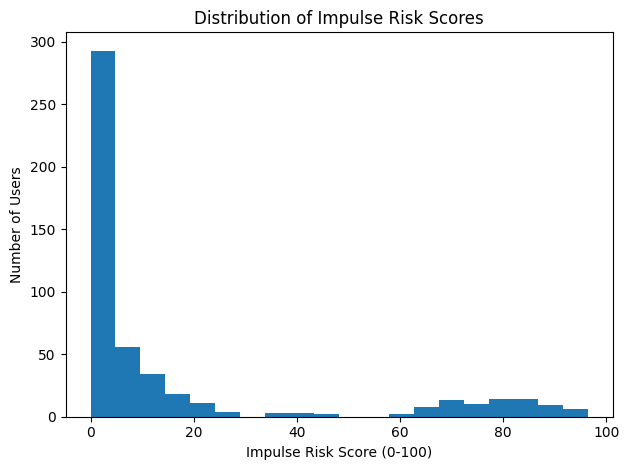

In [275]:
plt.figure()
plt.hist(user_features["risk_score"], bins=20)
plt.xlabel("Impulse Risk Score (0-100)")
plt.ylabel("Number of Users")
plt.title("Distribution of Impulse Risk Scores")
plt.tight_layout()
plt.show()

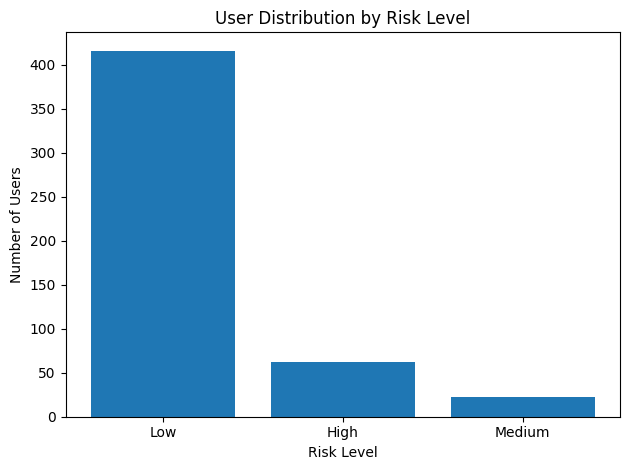

In [276]:
risk_counts = user_features["risk_level"].value_counts()

plt.figure()
plt.bar(risk_counts.index, risk_counts.values)
plt.xlabel("Risk Level")
plt.ylabel("Number of Users")
plt.title("User Distribution by Risk Level")
plt.tight_layout()
plt.show()

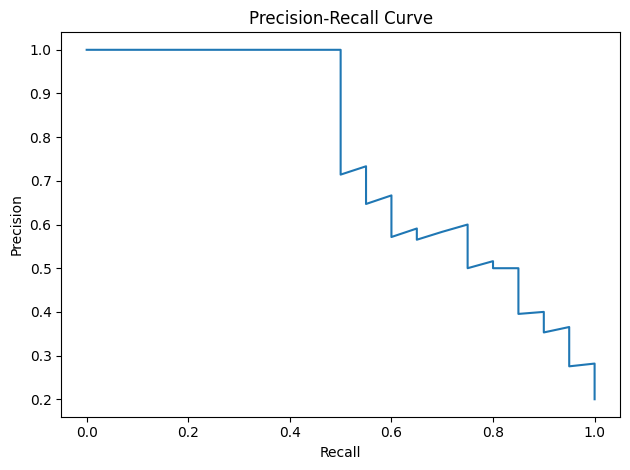

In [277]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

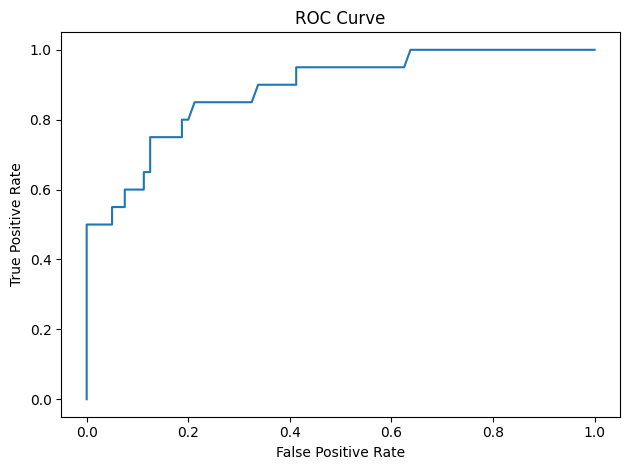

In [278]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.tight_layout()
plt.show()

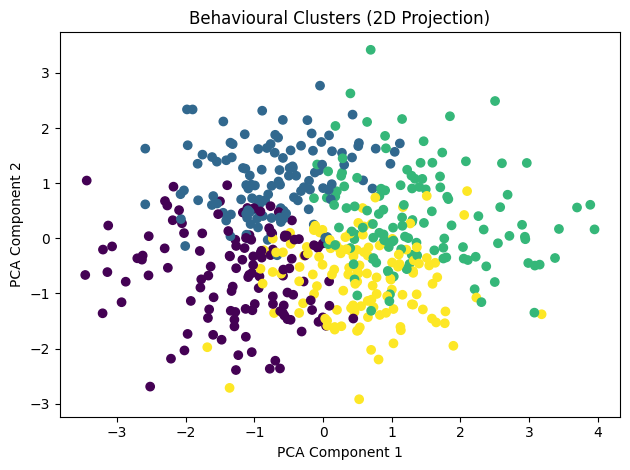

In [279]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_data)

plt.figure()
plt.scatter(reduced[:,0], reduced[:,1], c=user_features["cluster"])
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Behavioural Clusters (2D Projection)")
plt.tight_layout()
plt.show()

/tmp/ipython-input-204/3132036016.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:, :, 1], X_test)


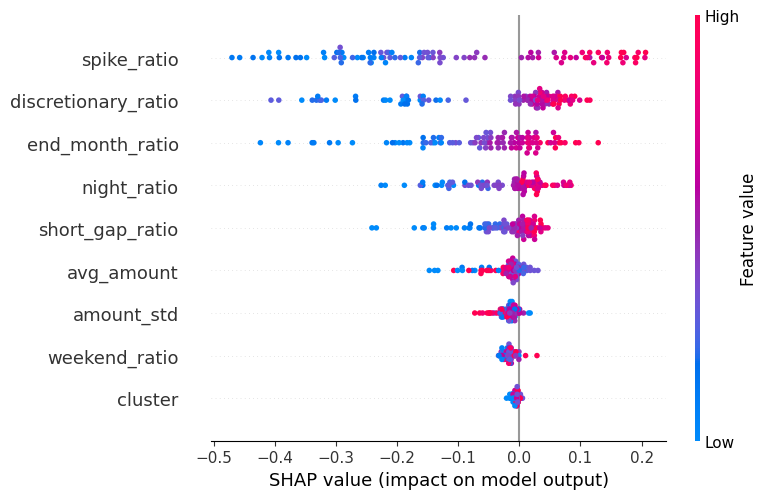

In [280]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[:, :, 1], X_test)

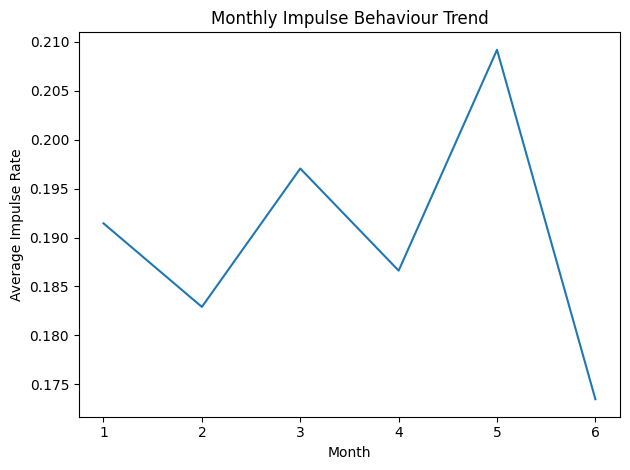

In [281]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df["month"] = df["transaction_time"].dt.month

monthly_impulse = df.groupby("month")["impulse_label"].mean()

plt.figure()
plt.plot(monthly_impulse.index, monthly_impulse.values)
plt.xlabel("Month")
plt.ylabel("Average Impulse Rate")
plt.title("Monthly Impulse Behaviour Trend")
plt.tight_layout()
plt.show()

## Save Model Using Joblib

In [ ]:
import joblib

joblib.dump(model2, "impulse_model.joblib")
joblib.dump(scaler, "scaler.joblib")
joblib.dump(user_features, "user_features.joblib")

['user_features.joblib']